# Audio Recognition

In [1]:
#import pyaudio
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
import numpy as np
import pandas as pd
import random
from skimage.measure import block_reduce
# from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

#To find the duration of wave file in seconds
import wave
import contextlib
import librosa
import soundfile as sf

#Keras imports
import keras
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
import tensorflow as tf

import time
import datetime

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
def save_model_to_disk(model):
    """
    Converts the model to a json and saves as an h5 file
    """
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to disk")

def normalize_gray(array):
    """
    Normalize Gray colored image
    """
    return (array - array.min())/(array.max() - array.min())

def findDuration(fname):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        sw   = f.getsampwidth()
        chan = f.getnchannels()
        duration = frames / float(rate)
        #print("File:", fname, "--->",frames, rate, sw, chan)
        return duration
        
def graph_spectrogram(wav_file, nfft=512, noverlap=256):
    """
    Converts the wav file to a spectrogram for the NN to interpret
    """
    findDuration(wav_file)
    rate, data = wavfile.read(wav_file)
    #print("")
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    # pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=noverlap, NFFT=nfft)
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, cmap="gray", noverlap=noverlap, NFFT=nfft)
    ax.axis('off')
    plt.rcParams['figure.figsize'] = [0.75,0.5]
    #fig.savefig('sp_xyz.png', dpi=300, frameon='false')
    fig.canvas.draw()
    size_inches  = fig.get_size_inches()
    dpi          = fig.get_dpi()
    width, height = fig.get_size_inches() * fig.get_dpi()

    #print(size_inches, dpi, width, height)
    mplimage = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    #print("MPLImage Shape: ", np.shape(mplimage))
    imarray = np.reshape(mplimage, (int(height), int(width), 3))
#     plt.plot(fig)
    plt.close(fig)
#     print(f'imarray shape: {imarray[:,:,1].shape}')
    return imarray[:,:,1]

## Creating a Directory for the Files

In [4]:
# os.environ['KMP_DUPLICATE_LIB_OK']  = 'True'

folder_names = [f for f in os.listdir('train/audio') if not 'background' in f]
folder_names.sort()

imheight = int(17)
imwidth = int(25)
k = int(0)

In [5]:
file = open("train/testing_list.txt", "r")
testing_list = file.read().split('\n')
file.close()
file = open("train/validation_list.txt", "r")
validation_list = file.read().split('\n')

In [6]:
master_file_list = []
master_target_list = []
train_val_test_list = []
for phrase in folder_names:
    file_list = [phrase + '/' + f for f in os.listdir('train/audio/' + phrase) if '.wav' in f]
    for file in file_list:
        if file in testing_list:
            train_val_test_list.append('test')
        elif file in validation_list:
            train_val_test_list.append('val')
        else:
            train_val_test_list.append('train')
        master_target_list.append(phrase)
        master_file_list.append(file)
data = np.transpose(np.array([master_file_list, master_target_list, train_val_test_list]))
master_df = pd.DataFrame(data = data, columns=['filename','target','train_val_test'])
master_df.head()

,filename,target,train_val_test
0,bed/00176480_nohash_0.wav,bed,train
1,bed/004ae714_nohash_0.wav,bed,train
2,bed/004ae714_nohash_1.wav,bed,train
3,bed/00f0204f_nohash_0.wav,bed,train
4,bed/00f0204f_nohash_1.wav,bed,train


## Creating the Keras Model

In [7]:
def new_keras():
    # low vram utilization, try changing or adding conv layers 
    # input_shape = (imheight, imwidth, 1)
    input_shape = (36, 54, 1)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=0.01) #if not converging try increasing
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    return model

In [8]:
def load_waves(fpath):
    fpath = 'train/audio/' + fpath
    spectrogram = graph_spectrogram(fpath)
#     graygram = rgb2gray(spectrogram)
    normgram = normalize_gray(spectrogram)
#     norm_shape = normgram.shape
#     redgram = block_reduce(normgram, block_size = (3,3), func = np.mean)
#     return redgram
    return(normgram)

In [9]:
def plot_results(history):
    # change figsize back to default size
    plt.rcParams['figure.figsize'] = [6.4, 4.8]
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Label mapping: {'yes': 0, 'wow': 1, 'go': 2, 'stop': 3, 'marvin': 4, 'bird': 5, 'two': 6, 'four': 7, 'zero': 8, 'up': 9, 'nine': 10, 'down': 11, 'three': 12, 'on': 13, 'eight': 14, 'house': 15, 'off': 16, 'six': 17, 'no': 18, 'seven': 19, 'sheila': 20, 'happy': 21, 'bed': 22, 'dog': 23, 'five': 24, 'tree': 25, 'right': 26, 'one': 27, 'left': 28, 'cat': 29}
working on batch: 1/10
loading training images


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7544: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


loading validation images
reshaping...
xtrain shape:(4341, 36, 54, 1)
xval shape:(1448, 36, 54, 1)
Epoch 1/5
1086/1086 [==============================] - 8s 7ms/step - loss: 3.3998 - accuracy: 0.0323 - val_loss: 3.4068 - val_accuracy: 0.0338
Epoch 2/5
1086/1086 [==============================] - 7s 7ms/step - loss: 3.4001 - accuracy: 0.0290 - val_loss: 3.4014 - val_accuracy: 0.0394
Epoch 3/5
1086/1086 [==============================] - 7s 7ms/step - loss: 3.4002 - accuracy: 0.0355 - val_loss: 3.4014 - val_accuracy: 0.0283
Epoch 4/5
1086/1086 [==============================] - 7s 7ms/step - loss: 3.3987 - accuracy: 0.0320 - val_loss: 3.4021 - val_accuracy: 0.0325
Epoch 5/5
1086/1086 [==============================] - 7s 7ms/step - loss: 3.3992 - accuracy: 0.0336 - val_loss: 3.4066 - val_accuracy: 0.0283


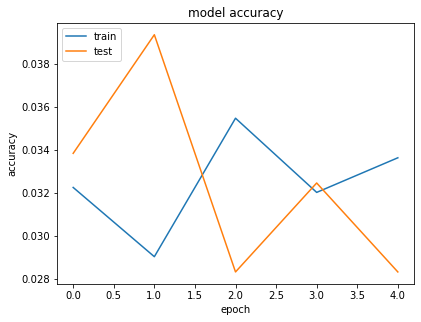

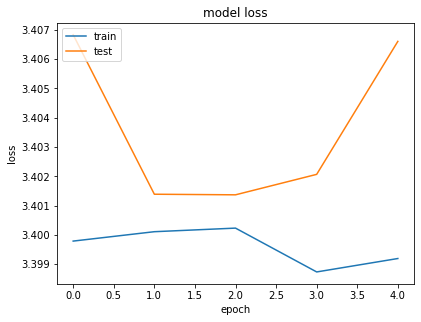

INFO:tensorflow:Assets written to: ./MyModel_tf\assets


TypeError: 'int' object is not subscriptable

In [18]:
num_classes = len(master_df['target'].unique().tolist())
#SKF is just being used to batch the data into memory, not do any sort of k-fold training process
total_splits = 10

skf = StratifiedKFold(n_splits=total_splits, shuffle=True, random_state=42)

X_master = master_df['filename'][[(val in ['train','val']) for val in master_df['train_val_test']]]
y_master = master_df['target'][[(val in ['train','val']) for val in master_df['train_val_test']]]
X_master, y_master = np.array(X_master), np.array(y_master)

# from https://www.educative.io/edpresso/how-to-perform-one-hot-encoding-using-keras
# also has link to OHE using sklearn
y_master_set = list(set(y_master))
mapping = {}
for x in range(len(y_master_set)):
    mapping[y_master_set[x]] = x
print(f'Label mapping: {mapping}')

batch_count = 1
for train_index, test_index in skf.split(X_master, y_master):
    print(f'working on batch: {batch_count}/{total_splits}')
    rs = ShuffleSplit(n_splits=2, test_size=.25, random_state=42)
#     rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=42)
    X, y = X_master[test_index], y_master[test_index]
    for train_index2, test_index2 in rs.split(X):
        #should only run once but is currently running twice (w/ n_splits = 2)
        X_train, X_val = X[train_index2], X[test_index2]
        y_train, y_val = y[train_index2], y[test_index2]
        # Split is done, X=filename, y=target

        train_sound_clips = []
        val_sound_clips = []
        
        print(f'loading training images')
        for fpath in X_train:
            # update code to `try` loading pickles
            # or preprocess sound clips and save as pickles
            redgram = load_waves(fpath)
            # print(np.shape(redgram))
            # redgram shape is (36, 54)
            train_sound_clips.append(redgram)
#         playing with dtypes...
#         train_sound_clips = np.array(train_sound_clips, dtype=object)
#         train_sound_clips = np.asarray(train_sound_clips).astype('float32')
#         train_sound_clips = train_sound_clips.astype('float32')
        train_sound_clips = np.array(train_sound_clips, dtype=np.float32)
        
        print(f'loading validation images')
        for fpath in X_val:
            redgram = np.array(load_waves(fpath))
            val_sound_clips.append(redgram)
#         playing with dtypes...
#         val_sound_clips = np.array(val_sound_clips, dtype=object)
#         val_sound_clips = np.asarray(val_sound_clips).astype('float32')
#         val_sound_clips = val_sound_clips.astype('float32')
        val_sound_clips = np.array(val_sound_clips, dtype=np.float32)
        
        print('reshaping...')
        x_train = train_sound_clips.reshape(X_train.shape[0],
                                            train_sound_clips.shape[1], 
                                            train_sound_clips.shape[2],1)
        print(f'xtrain shape:{x_train.shape}')
        for y in range(len(y_train)):
            y_train[y] = mapping[y_train[y]]
        y_train = keras.utils.to_categorical(y_train, num_classes)
        
        x_val = val_sound_clips.reshape(X_val.shape[0],
                                        val_sound_clips.shape[1],
                                        val_sound_clips.shape[2],1)
        print(f'xval shape:{x_val.shape}')
        for y in range(len(y_val)):
            y_val[y] = mapping[y_val[y]]
        y_val = keras.utils.to_categorical(y_val, num_classes)
        
        try:
            loaded_model = tf.keras.models.load_model('./MyModel_tf')
            history = loaded_model.fit(x_train, y_train, batch_size=4, epochs=5, verbose=1, validation_data=(x_val, y_val))
            plot_results(history)
            loaded_model.save('./MyModel_tf',save_format='tf')
        except:
            print("Starting with a fresh model")
            model = new_keras()
            history = model.fit(x_train, y_train, batch_size=4, epochs=5, verbose=1, validation_data=(x_val, y_val))
            plot_results(history)
            model.save('./MyModel_tf',save_format='tf')
            model=[]
    print(f'done with batch:{batch_count}/{total_splits}')
    batch_count += 1